In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import calendar

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import cross_val_score

import lightgbm as lgb

In [2]:
path = "/Users/utotakahiro/Documents/GCI/competition3/"

df = pd.read_csv(path + 'train.csv')
df_test = pd.read_csv(path + 'test.csv')

In [3]:
print('訓練データのデータ数は{}、変数は{}種類です。'.format(df.shape[0], df.shape[1]))
print('テストデータのデータ数は{}、変数は{}種類です'.format(df_test.shape[0], df_test.shape[1]))

訓練データのデータ数は2882335、変数は6種類です。
テストデータのデータ数は214200、変数は3種類です


In [4]:
df_goods = pd.read_csv(path + 'goods.csv')
df_stores = pd.read_csv(path + 'stores.csv')
df_genres = pd.read_csv(path + 'genres.csv')

### カラム情報一覧
データに含まれるカラムの情報は以下です。
* index ... (店舗, 商品) の各組み合わせに対してわりふられるID
* store_id ... 店舗ID
* goods_id ... 商品ID
* goods_genre_id ... 商品カテゴリID
* units_sold_day ... 商品の一日の売り上げ個数
* units_sold_month ... 商品のひと月の売り上げ個数 (今回の予測のターゲット)
* price ... 商品の現在の値段
* yy-mm-dd ... 日付 (yy/mm/dd形式)
* num_month ... 便宜上各月にわりふられた値 (平成25年1月=1, 平成25年2月=2,...,平成27年9月=33)
* goods_name ... 商品名
* store_name ... 店舗名
* goods_genre_name ... 商品カテゴリ名

In [5]:
#(1,58),(2,59)のstore_idの組み合わせが同じ
df[df['store_id']==1]['store_id'] = 58
df[df['store_id']==2]['store_id'] = 59

df_test[df_test['store_id']==1]['store_id'] = 58
df_test[df_test['store_id']==2]['store_id'] = 59

## EDA  
### 欠損値

In [6]:
df.isnull().sum() 

yy_mm_dd          0
num_month         0
store_id          0
goods_id          0
price             0
units_sold_day    0
dtype: int64

In [7]:
df_test.isnull().sum() 

index       0
store_id    0
goods_id    0
dtype: int64

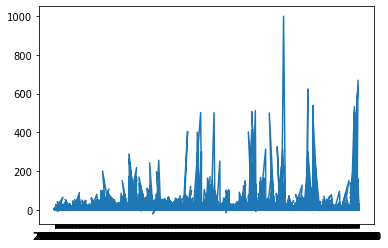

In [8]:
#for x in ['num_month', 'store_id', 'goods_id', 'price', 'units_sold_day']:
plt.plot(df['yy_mm_dd'],df['units_sold_day'])

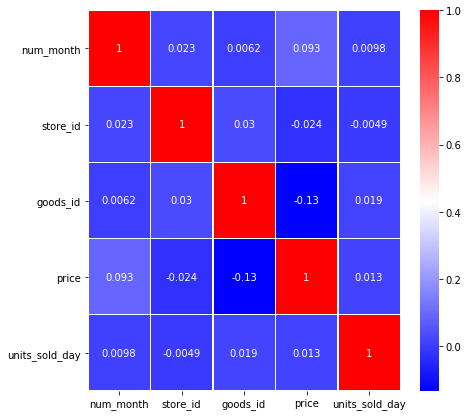

In [9]:
sns.heatmap(df.corr(),annot=True,cmap='bwr',linewidths=0.4)
fig=plt.gcf()
fig.set_size_inches(7,7)
plt.show()

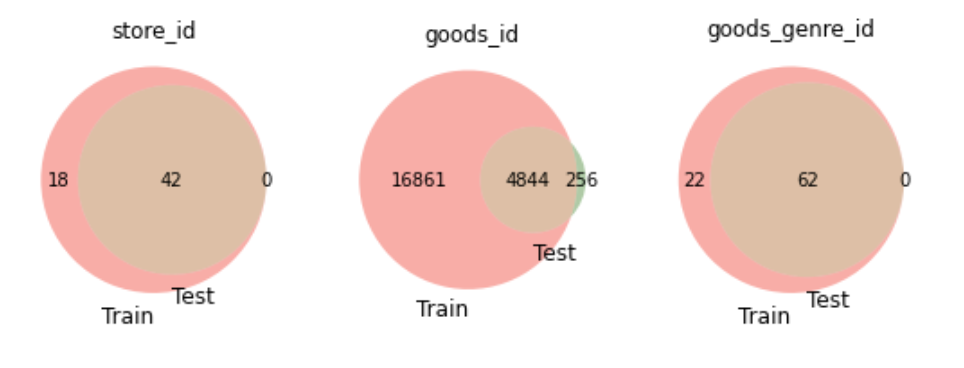

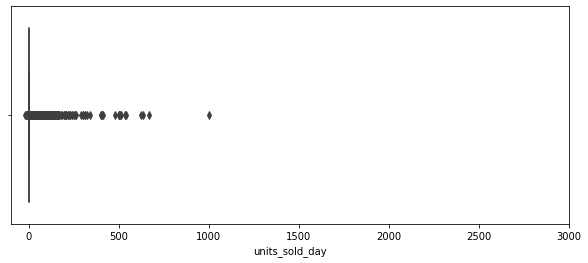

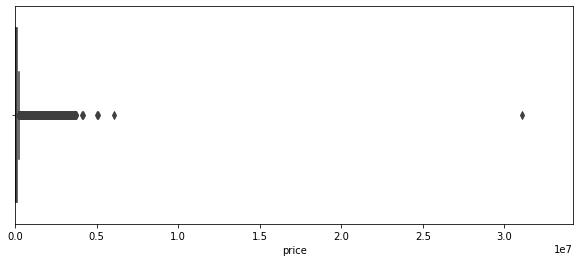

In [10]:
#特異値が無いかチェック
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=df.units_sold_day)

plt.figure(figsize=(10,4))
plt.xlim(df.price.min(), df.price.max()*1.1)
sns.boxplot(x=df.price)

In [11]:
#特異値をカット
df = df[df.price<100000]
df = df[df.units_sold_day<1001]

In [12]:
#値段が0未満のものがないかチェック
df[df['price'] < 0]

,yy_mm_dd,num_month,store_id,goods_id,price,units_sold_day
483385,25-05-15,-29,33,2974,-97,1


In [13]:
mean = df[(df['goods_id']==2974)&(df['price']>0)]['price'].mean()
df[df['price']<0]['price'] = mean

日付などの情報を取り出す

In [14]:
# 年月日を、年・月・日に分割
df['year'] = df['yy_mm_dd'].apply(lambda x: int(str(x)[0:2]))
df['month'] = df['yy_mm_dd'].apply(lambda x: int(str(x)[3:5]))
df['day'] = df['yy_mm_dd'].apply(lambda x: int(str(x)[6:]))

df

,yy_mm_dd,num_month,store_id,goods_id,price,units_sold_day,year,month,day
0,25-01-29,-33,43,17718,44943,2,25,1,29
1,25-01-08,-33,32,8648,14949,1,25,1,8
2,25-01-16,-33,53,10168,30158,1,25,1,16
3,25-01-23,-33,31,1005,9922,1,25,1,23
4,25-01-12,-33,27,19861,14988,0,25,1,12
...,...,...,...,...,...,...,...,...,...
2882330,27-09-29,-1,26,14804,79975,3,27,9,29
2882331,27-09-12,-1,18,7873,2809,1,27,9,12
2882332,27-09-08,-1,57,4562,75213,1,27,9,8
2882333,27-09-07,-1,27,7173,73545,1,27,9,7


基準日を設定

In [15]:
# 基準日を2010年1月1日に設定
start_date = pd.Timestamp('2013-01-01')


# 基準日との差分を格納
df['total_days'] = df['yy_mm_dd'].apply(lambda x: (datetime.datetime(int(str(x)[0:2])+2000 - 12,int(str(x)[3:5]),int(str(x)[6:])) - start_date).days)

df

,yy_mm_dd,num_month,store_id,goods_id,price,units_sold_day,year,month,day,total_days
0,25-01-29,-33,43,17718,44943,2,25,1,29,28
1,25-01-08,-33,32,8648,14949,1,25,1,8,7
2,25-01-16,-33,53,10168,30158,1,25,1,16,15
3,25-01-23,-33,31,1005,9922,1,25,1,23,22
4,25-01-12,-33,27,19861,14988,0,25,1,12,11
...,...,...,...,...,...,...,...,...,...,...
2882330,27-09-29,-1,26,14804,79975,3,27,9,29,1001
2882331,27-09-12,-1,18,7873,2809,1,27,9,12,984
2882332,27-09-08,-1,57,4562,75213,1,27,9,8,980
2882333,27-09-07,-1,27,7173,73545,1,27,9,7,979


In [16]:
couple = df.drop(['price', 'units_sold_day', 'year', 'month','day', 'total_days'],
                 axis = 1).groupby(['store_id','goods_id','num_month']).size().index.values
df_found = pd.DataFrame(list(couple),columns = ['store_id','goods_id','num_month'])
df_found

,store_id,goods_id,num_month
0,1,30,-32
1,1,31,-32
2,1,32,-32
3,1,33,-33
4,1,33,-32
...,...,...,...
1374825,60,22165,-6
1374826,60,22165,-3
1374827,60,22168,-24
1374828,60,22168,-22


## ラグ特徴量をつくる  
25年1月から27年9月までのデータ。とりあえず27年の分を作ってみる。

In [17]:
#１ヶ月の売れた個数
def qty(m):
    df_qty = df[df['num_month'] == m].loc[:, ['store_id','goods_id','num_month','units_sold_day']]
    se_qty = df_qty.groupby(['store_id','goods_id','num_month'])['units_sold_day'].sum()
    df_qty_1 = pd.DataFrame(list(se_qty.index),columns = ['store_id','goods_id','num_month'])
    df_qty_1['qty'] = se_qty.values
    
    return df_qty_1

In [18]:
qty(-32)

,store_id,goods_id,num_month,qty
0,1,30,-32,3
1,1,31,-32,31
2,1,32,-32,9
3,1,33,-32,8
4,1,34,-32,4
...,...,...,...,...
55140,60,22021,-32,2
55141,60,22025,-32,1
55142,60,22088,-32,1
55143,60,22131,-32,2


In [19]:
# ２５年までの分全て
df_qty_con = qty(-33).copy()

for i in range(-32,0):
    df_qty_con = pd.concat([df_qty_con, qty(i)])

In [20]:
df_qty_con

,store_id,goods_id,num_month,qty
0,1,33,-33,6
1,1,34,-33,2
2,1,36,-33,1
3,1,44,-33,1
4,1,52,-33,2
...,...,...,...,...
22792,60,22088,-1,3
22793,60,22089,-1,1
22794,60,22092,-1,3
22795,60,22101,-1,1


In [21]:
df_all = pd.merge(df_found, df_qty_con, how = 'left')
df_all

,store_id,goods_id,num_month,qty
0,1,30,-32,3
1,1,31,-32,31
2,1,32,-32,9
3,1,33,-33,6
4,1,33,-32,8
...,...,...,...,...
1374825,60,22165,-6,2
1374826,60,22165,-3,1
1374827,60,22168,-24,1
1374828,60,22168,-22,2


In [22]:
#集約
num_lis = [1, 2, 3, 6, 12]
lis_for = []
# データは27年8月以前のものを使う
start_num = -2

for i in num_lis:
    lis_col = [-i for i in range(abs(start_num),abs(start_num) + i)]
    
    se = df_all[df_all['num_month'].isin(lis_col)].groupby(['store_id','goods_id'])['qty'].mean()
    df_lis = pd.DataFrame(list(se.index),columns = ['store_id','goods_id'])
    df_lis['qty_'+str(i)+'month'] = se.values
    
    df_all = df_all.merge(df_lis, how = 'left').fillna(0)
    
df_all

,store_id,goods_id,num_month,qty,qty_1month,qty_2month,qty_3month,qty_6month,qty_12month
0,1,30,-32,3,0.0,0.0,0.0,0.000000,0.0
1,1,31,-32,31,0.0,0.0,0.0,0.000000,0.0
2,1,32,-32,9,0.0,0.0,0.0,0.000000,0.0
3,1,33,-33,6,0.0,0.0,0.0,0.000000,0.0
4,1,33,-32,8,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...
1374825,60,22165,-6,2,0.0,1.0,1.0,1.333333,1.5
1374826,60,22165,-3,1,0.0,1.0,1.0,1.333333,1.5
1374827,60,22168,-24,1,0.0,0.0,0.0,0.000000,0.0
1374828,60,22168,-22,2,0.0,0.0,0.0,0.000000,0.0


## 買われた回数を追加

In [23]:
#1ヶ月に買われた回数
def cnt(m):
    df_cnt = df[df['num_month'] == m].loc[:, ['store_id','goods_id','num_month','yy_mm_dd']]
    se_cnt = df_cnt.groupby(['store_id','goods_id','num_month'])['yy_mm_dd'].size()
    df_cnt_1 = pd.DataFrame(list(se_cnt.index),columns = ['store_id','goods_id','num_month'])
    df_cnt_1['cnt'] = se_cnt.values
    
    return df_cnt_1

In [24]:
# ２５年までの分全て
df_cnt_con = cnt(-33).copy()

for i in range(-32,0):
    df_cnt_con = pd.concat([df_cnt_con, cnt(i)])

df_all = pd.merge(df_all, df_cnt_con, how = 'left')

In [25]:
df_cnt_con

,store_id,goods_id,num_month,cnt
0,1,33,-33,4
1,1,34,-33,2
2,1,36,-33,1
3,1,44,-33,1
4,1,52,-33,2
...,...,...,...,...
22792,60,22088,-1,2
22793,60,22089,-1,1
22794,60,22092,-1,3
22795,60,22101,-1,1


In [26]:
#集約
num_lis = [1, 2, 3, 6, 12]
lis_for = []
# データは27年8月以前のものを使う
start_num = -2

for i in num_lis:
    lis_col = [-i for i in range(abs(start_num),abs(start_num) + i)]
    
    se = df_all[df_all['num_month'].isin(lis_col)].groupby(['store_id','goods_id'])['cnt'].mean()
    df_lis = pd.DataFrame(list(se.index),columns = ['store_id','goods_id'])
    df_lis['cnt_'+str(i)+'month'] = se.values
    
    df_all = df_all.merge(df_lis, how = 'left').fillna(0)
    
df_all

,store_id,goods_id,num_month,qty,qty_1month,qty_2month,qty_3month,qty_6month,qty_12month,cnt,cnt_1month,cnt_2month,cnt_3month,cnt_6month,cnt_12month
0,1,30,-32,3,0.0,0.0,0.0,0.000000,0.0,1,0.0,0.0,0.0,0.000000,0.0
1,1,31,-32,31,0.0,0.0,0.0,0.000000,0.0,10,0.0,0.0,0.0,0.000000,0.0
2,1,32,-32,9,0.0,0.0,0.0,0.000000,0.0,5,0.0,0.0,0.0,0.000000,0.0
3,1,33,-33,6,0.0,0.0,0.0,0.000000,0.0,4,0.0,0.0,0.0,0.000000,0.0
4,1,33,-32,8,0.0,0.0,0.0,0.000000,0.0,6,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1374825,60,22165,-6,2,0.0,1.0,1.0,1.333333,1.5,2,0.0,1.0,1.0,1.333333,1.5
1374826,60,22165,-3,1,0.0,1.0,1.0,1.333333,1.5,1,0.0,1.0,1.0,1.333333,1.5
1374827,60,22168,-24,1,0.0,0.0,0.0,0.000000,0.0,1,0.0,0.0,0.0,0.000000,0.0
1374828,60,22168,-22,2,0.0,0.0,0.0,0.000000,0.0,2,0.0,0.0,0.0,0.000000,0.0


## 店の直前の期間の売り上げ平均のカラムをつくる

In [27]:
df['store_income'] = df['price']*df['units_sold_day']

In [28]:
def inc(m):
    df_ic = df[df['num_month'] == m].loc[:, ['store_id','goods_id','num_month','store_income']]
    se_ic = df_ic.groupby(['store_id','goods_id','num_month'])['store_income'].mean()
    df_ic_1 = pd.DataFrame(list(se_ic.index),columns = ['store_id','goods_id','num_month'])
    df_ic_1['inc'] = se_ic.values
    
    return df_ic_1

In [29]:
# ２５年までの分全て
df_inc_con = inc(-33).copy()

for i in range(-32,0):
    df_inc_con = pd.concat([df_inc_con, inc(i)])

df_all = pd.merge(df_all, df_inc_con, how = 'left')

In [30]:
#集約
num_lis = [1, 2, 3, 6, 12]
lis_for = []
# データは27年8月以前のものを使う
start_num = -2

for i in num_lis:
    lis_col = [-i for i in range(abs(start_num),abs(start_num) + i)]
    
    se = df_all[df_all['num_month'].isin(lis_col)].groupby(['store_id','goods_id'])['inc'].mean()
    df_lis = pd.DataFrame(list(se.index),columns = ['store_id','goods_id'])
    df_lis['inc_'+str(i)+'month'] = se.values
    
    df_all = df_all.merge(df_lis, how = 'left').fillna(0)
    
df_all

,store_id,goods_id,num_month,qty,qty_1month,qty_2month,qty_3month,qty_6month,qty_12month,cnt,...,cnt_2month,cnt_3month,cnt_6month,cnt_12month,inc,inc_1month,inc_2month,inc_3month,inc_6month,inc_12month
0,1,30,-32,3,0.0,0.0,0.0,0.000000,0.0,1,...,0.0,0.0,0.000000,0.0,80313.00,0.0,0.0,0.0,0.000000,0.00
1,1,31,-32,31,0.0,0.0,0.0,0.000000,0.0,10,...,0.0,0.0,0.000000,0.0,83090.30,0.0,0.0,0.0,0.000000,0.00
2,1,32,-32,9,0.0,0.0,0.0,0.000000,0.0,5,...,0.0,0.0,0.000000,0.0,77929.60,0.0,0.0,0.0,0.000000,0.00
3,1,33,-33,6,0.0,0.0,0.0,0.000000,0.0,4,...,0.0,0.0,0.000000,0.0,33131.75,0.0,0.0,0.0,0.000000,0.00
4,1,33,-32,8,0.0,0.0,0.0,0.000000,0.0,6,...,0.0,0.0,0.000000,0.0,32728.00,0.0,0.0,0.0,0.000000,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1374825,60,22165,-6,2,0.0,1.0,1.0,1.333333,1.5,2,...,1.0,1.0,1.333333,1.5,69635.50,0.0,69418.0,69418.0,71588.833333,72308.25
1374826,60,22165,-3,1,0.0,1.0,1.0,1.333333,1.5,1,...,1.0,1.0,1.333333,1.5,69418.00,0.0,69418.0,69418.0,71588.833333,72308.25
1374827,60,22168,-24,1,0.0,0.0,0.0,0.000000,0.0,1,...,0.0,0.0,0.000000,0.0,29717.00,0.0,0.0,0.0,0.000000,0.00
1374828,60,22168,-22,2,0.0,0.0,0.0,0.000000,0.0,2,...,0.0,0.0,0.000000,0.0,29582.50,0.0,0.0,0.0,0.000000,0.00


## goods_genre_id

In [31]:
#goodsのジャンルの情報も加える。
# Label-Count Encodingの適用
df_all = pd.merge(df_all,df_goods.iloc[:,1:],how = 'left')
x = df_all['goods_genre_id']
df_all['goods_genre_id_lce'] = x.map(x.value_counts().rank(ascending=False, method='first'))

df_all = df_all.drop('goods_genre_id', axis = 1).fillna(0)

In [32]:
df_test

,index,store_id,goods_id
0,0,3,15900
1,1,3,18326
2,2,3,5665
3,3,3,15859
4,4,3,8826
...,...,...,...
214195,214195,60,8851
214196,214196,60,1539
214197,214197,60,13719
214198,214198,60,6074


In [33]:
df_all_1 = df_all.drop('num_month',axis = 1).groupby(['store_id','goods_id']).mean().reset_index()
df_all_1

,store_id,goods_id,qty,qty_1month,qty_2month,qty_3month,qty_6month,qty_12month,cnt,cnt_1month,...,cnt_3month,cnt_6month,cnt_12month,inc,inc_1month,inc_2month,inc_3month,inc_6month,inc_12month,goods_genre_id_lce
0,1,30,3.000000,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,...,0.0,0.000000,0.0,80313.000,0.0,0.0,0.0,0.000000,0.00,7.0
1,1,31,31.000000,0.0,0.0,0.0,0.000000,0.0,10.000000,0.0,...,0.0,0.000000,0.0,83090.300,0.0,0.0,0.0,0.000000,0.00,1.0
2,1,32,9.000000,0.0,0.0,0.0,0.000000,0.0,5.000000,0.0,...,0.0,0.000000,0.0,77929.600,0.0,0.0,0.0,0.000000,0.00,3.0
3,1,33,7.000000,0.0,0.0,0.0,0.000000,0.0,5.000000,0.0,...,0.0,0.000000,0.0,32929.875,0.0,0.0,0.0,0.000000,0.00,1.0
4,1,34,3.000000,0.0,0.0,0.0,0.000000,0.0,3.000000,0.0,...,0.0,0.000000,0.0,33472.625,0.0,0.0,0.0,0.000000,0.00,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427718,60,22156,1.000000,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,...,0.0,0.000000,0.0,14776.000,0.0,0.0,0.0,0.000000,0.00,3.0
427719,60,22163,3.400000,1.0,1.0,1.0,2.250000,3.4,3.400000,1.0,...,1.0,2.250000,3.4,37233.760,34608.0,34608.0,34608.0,36582.700000,37233.76,1.0
427720,60,22164,1.000000,0.0,0.0,0.0,0.000000,1.0,1.000000,0.0,...,0.0,0.000000,1.0,39868.000,0.0,0.0,0.0,0.000000,39868.00,1.0
427721,60,22165,1.500000,0.0,1.0,1.0,1.333333,1.5,1.500000,0.0,...,1.0,1.333333,1.5,72308.250,0.0,69418.0,69418.0,71588.833333,72308.25,3.0


In [34]:
df_test_1 = df_test.merge(df_all_1, how='left').fillna(0)

In [35]:
df_all

,store_id,goods_id,num_month,qty,qty_1month,qty_2month,qty_3month,qty_6month,qty_12month,cnt,...,cnt_3month,cnt_6month,cnt_12month,inc,inc_1month,inc_2month,inc_3month,inc_6month,inc_12month,goods_genre_id_lce
0,1,30,-32,3,0.0,0.0,0.0,0.000000,0.0,1,...,0.0,0.000000,0.0,80313.00,0.0,0.0,0.0,0.000000,0.00,7.0
1,1,31,-32,31,0.0,0.0,0.0,0.000000,0.0,10,...,0.0,0.000000,0.0,83090.30,0.0,0.0,0.0,0.000000,0.00,1.0
2,1,32,-32,9,0.0,0.0,0.0,0.000000,0.0,5,...,0.0,0.000000,0.0,77929.60,0.0,0.0,0.0,0.000000,0.00,3.0
3,1,33,-33,6,0.0,0.0,0.0,0.000000,0.0,4,...,0.0,0.000000,0.0,33131.75,0.0,0.0,0.0,0.000000,0.00,1.0
4,1,33,-32,8,0.0,0.0,0.0,0.000000,0.0,6,...,0.0,0.000000,0.0,32728.00,0.0,0.0,0.0,0.000000,0.00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1374825,60,22165,-6,2,0.0,1.0,1.0,1.333333,1.5,2,...,1.0,1.333333,1.5,69635.50,0.0,69418.0,69418.0,71588.833333,72308.25,3.0
1374826,60,22165,-3,1,0.0,1.0,1.0,1.333333,1.5,1,...,1.0,1.333333,1.5,69418.00,0.0,69418.0,69418.0,71588.833333,72308.25,3.0
1374827,60,22168,-24,1,0.0,0.0,0.0,0.000000,0.0,1,...,0.0,0.000000,0.0,29717.00,0.0,0.0,0.0,0.000000,0.00,20.0
1374828,60,22168,-22,2,0.0,0.0,0.0,0.000000,0.0,2,...,0.0,0.000000,0.0,29582.50,0.0,0.0,0.0,0.000000,0.00,20.0


In [36]:
df_all.columns

Index(['store_id', 'goods_id', 'num_month', 'qty', 'qty_1month', 'qty_2month',
       'qty_3month', 'qty_6month', 'qty_12month', 'cnt', 'cnt_1month',
       'cnt_2month', 'cnt_3month', 'cnt_6month', 'cnt_12month', 'inc',
       'inc_1month', 'inc_2month', 'inc_3month', 'inc_6month', 'inc_12month',
       'goods_genre_id_lce'],
      dtype='object')

In [37]:
df_test_1

,index,store_id,goods_id,qty,qty_1month,qty_2month,qty_3month,qty_6month,qty_12month,cnt,...,cnt_3month,cnt_6month,cnt_12month,inc,inc_1month,inc_2month,inc_3month,inc_6month,inc_12month,goods_genre_id_lce
0,0,3,15900,1.500000,1.0,1.5,1.500000,1.500000,1.500000,1.500000,...,1.500000,1.500000,1.500000,59496.500000,68961.0,59496.5,59496.500000,59496.500000,59496.500000,19.0
1,1,3,18326,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
2,2,3,5665,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
3,3,3,15859,2.000000,0.0,2.0,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,44342.500000,0.0,44342.5,44342.500000,44342.500000,44342.500000,16.0
4,4,3,8826,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,214195,60,8851,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
214196,214196,60,1539,4.000000,6.0,6.0,6.000000,6.000000,6.000000,1.500000,...,2.000000,2.000000,2.000000,124762.250000,145150.5,145150.5,145150.500000,145150.500000,145150.500000,5.0
214197,214197,60,13719,3.333333,2.0,4.0,3.333333,3.333333,3.333333,2.333333,...,2.333333,2.333333,2.333333,32004.666667,22598.5,25297.0,32004.666667,32004.666667,32004.666667,19.0
214198,214198,60,6074,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,98663.000000,98663.0,98663.0,98663.000000,98663.000000,98663.000000,26.0


In [38]:
df_test_1.columns

Index(['index', 'store_id', 'goods_id', 'qty', 'qty_1month', 'qty_2month',
       'qty_3month', 'qty_6month', 'qty_12month', 'cnt', 'cnt_1month',
       'cnt_2month', 'cnt_3month', 'cnt_6month', 'cnt_12month', 'inc',
       'inc_1month', 'inc_2month', 'inc_3month', 'inc_6month', 'inc_12month',
       'goods_genre_id_lce'],
      dtype='object')

In [39]:
df_test_1['num_month'] = 0
df_test_1 = df_test_1.reindex(columns= ['index', 'store_id', 'goods_id','num_month', 'qty', 'qty_1month', 'qty_2month',
       'qty_3month', 'qty_6month', 'qty_12month', 'cnt', 'cnt_1month',
       'cnt_2month', 'cnt_3month', 'cnt_6month', 'cnt_12month', 'inc',
       'inc_1month', 'inc_2month', 'inc_3month', 'inc_6month', 'inc_12month',
       'goods_genre_id_lce']).iloc[:,1:]
df_test_1

,store_id,goods_id,num_month,qty,qty_1month,qty_2month,qty_3month,qty_6month,qty_12month,cnt,...,cnt_3month,cnt_6month,cnt_12month,inc,inc_1month,inc_2month,inc_3month,inc_6month,inc_12month,goods_genre_id_lce
0,3,15900,0,1.500000,1.0,1.5,1.500000,1.500000,1.500000,1.500000,...,1.500000,1.500000,1.500000,59496.500000,68961.0,59496.5,59496.500000,59496.500000,59496.500000,19.0
1,3,18326,0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
2,3,5665,0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
3,3,15859,0,2.000000,0.0,2.0,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,44342.500000,0.0,44342.5,44342.500000,44342.500000,44342.500000,16.0
4,3,8826,0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,60,8851,0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
214196,60,1539,0,4.000000,6.0,6.0,6.000000,6.000000,6.000000,1.500000,...,2.000000,2.000000,2.000000,124762.250000,145150.5,145150.5,145150.500000,145150.500000,145150.500000,5.0
214197,60,13719,0,3.333333,2.0,4.0,3.333333,3.333333,3.333333,2.333333,...,2.333333,2.333333,2.333333,32004.666667,22598.5,25297.0,32004.666667,32004.666667,32004.666667,19.0
214198,60,6074,0,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,98663.000000,98663.0,98663.0,98663.000000,98663.000000,98663.000000,26.0


# Base line model

最新月の9月をyのデータに割り当てる

In [40]:
def main():
    lgbm_params = {
        'objective': 'mse', 
        'metric': 'rmse',
        'feature_pre_filter': False,
        'lambda_l1': 4.116109380718089e-06,
        'lambda_l2': 6.37628407431634e-05,
        'num_leaves': 9,
        'feature_fraction': 0.4,
        'bagging_fraction': 0.9906679705778775,
        'bagging_freq': 7,
        'min_child_samples': 20
    }
    
    #X_train:8, y_train:8, X_valid:9, y_valid:9, X_test:10
    X_train = df_all[(df_all['num_month'] < -1)&(df_all['num_month'] > -13)].drop(['qty','cnt','inc'], axis=1).values
    y_train = df_all[(df_all['num_month'] < -1)&(df_all['num_month'] > -13)]['qty']
    X_valid = df_all[df_all['num_month'] == -1].drop(['qty','cnt','inc'], axis=1).values
    y_valid = df_all[df_all['num_month'] == -1]['qty']
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
    model = lgb.train(lgbm_params, lgb_train, valid_sets=lgb_eval)

    y_pred = model.predict(X_valid)
    print('y_pred:',y_pred)
    print('---------------------')
    # RMSE を計算する
    mse = mean_squared_error(y_valid, y_pred)
    rmse = np.sqrt(mse)
    print('rmse:',rmse)
    print('---------------------')
    
    feature_scores = pd.Series(model.feature_importance(importance_type='gain'), index=df_all.drop(['qty','cnt','inc'],axis=1).columns).sort_values(ascending=False)
    se = feature_scores
    print(se.plot(kind='barh',figsize=(10, 10)))
    
    return model

In [41]:
def submission(m,n):
    X_test = df_test_1.drop(['qty','cnt','inc'], axis=1).values
    
    y_pred_sub = m.predict(X_test)    #.clip(0,20)
    
    print('y_pred_sub:',y_pred_sub)
    
    path = '/Users/utotakahiro/Documents/GCI/competition3/sample_submission.csv'
    submission = pd.read_csv(path)
    submission['units_sold_month'] = y_pred_sub
    
    submission.to_csv('/Users/utotakahiro/Documents/GCI/competition3/submission data/submission_feature_'+str(n)+'.csv', index=False)

[1]	valid_0's rmse: 4.95835
[2]	valid_0's rmse: 4.46358
[3]	valid_0's rmse: 4.07076
[4]	valid_0's rmse: 3.71982
[5]	valid_0's rmse: 3.44059
[6]	valid_0's rmse: 3.21024
[7]	valid_0's rmse: 3.03145
[8]	valid_0's rmse: 2.92545
[9]	valid_0's rmse: 2.82629
[10]	valid_0's rmse: 2.81833
[11]	valid_0's rmse: 2.7592
[12]	valid_0's rmse: 2.72551
[13]	valid_0's rmse: 2.69958
[14]	valid_0's rmse: 2.6844
[15]	valid_0's rmse: 2.696
[16]	valid_0's rmse: 2.72047
[17]	valid_0's rmse: 2.76872
[18]	valid_0's rmse: 2.76677
[19]	valid_0's rmse: 2.77851
[20]	valid_0's rmse: 2.82431
[21]	valid_0's rmse: 2.83715
[22]	valid_0's rmse: 2.82898
[23]	valid_0's rmse: 2.82845
[24]	valid_0's rmse: 2.85221
[25]	valid_0's rmse: 2.84761
[26]	valid_0's rmse: 2.88858
[27]	valid_0's rmse: 2.86299
[28]	valid_0's rmse: 2.85663
[29]	valid_0's rmse: 2.91203
[30]	valid_0's rmse: 2.87967
[31]	valid_0's rmse: 2.90228
[32]	valid_0's rmse: 2.89897
[33]	valid_0's rmse: 2.89857
[34]	valid_0's rmse: 2.90471
[35]	valid_0's rmse: 2.8967

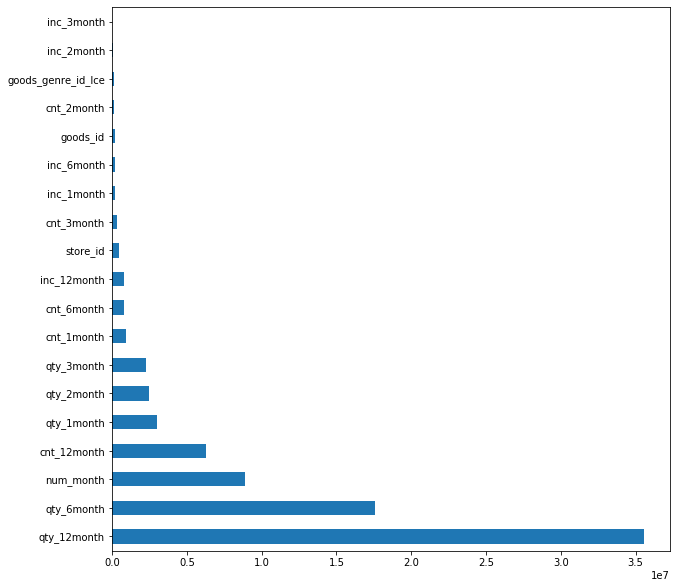

In [42]:
main()

[1]	valid_0's rmse: 4.95835
[2]	valid_0's rmse: 4.46358
[3]	valid_0's rmse: 4.07076
[4]	valid_0's rmse: 3.71982
[5]	valid_0's rmse: 3.44059
[6]	valid_0's rmse: 3.21024
[7]	valid_0's rmse: 3.03145
[8]	valid_0's rmse: 2.92545
[9]	valid_0's rmse: 2.82629
[10]	valid_0's rmse: 2.81833
[11]	valid_0's rmse: 2.7592
[12]	valid_0's rmse: 2.72551
[13]	valid_0's rmse: 2.69958
[14]	valid_0's rmse: 2.6844
[15]	valid_0's rmse: 2.696
[16]	valid_0's rmse: 2.72047
[17]	valid_0's rmse: 2.76872
[18]	valid_0's rmse: 2.76677
[19]	valid_0's rmse: 2.77851
[20]	valid_0's rmse: 2.82431
[21]	valid_0's rmse: 2.83715
[22]	valid_0's rmse: 2.82898
[23]	valid_0's rmse: 2.82845
[24]	valid_0's rmse: 2.85221
[25]	valid_0's rmse: 2.84761
[26]	valid_0's rmse: 2.88858
[27]	valid_0's rmse: 2.86299
[28]	valid_0's rmse: 2.85663
[29]	valid_0's rmse: 2.91203
[30]	valid_0's rmse: 2.87967
[31]	valid_0's rmse: 2.90228
[32]	valid_0's rmse: 2.89897
[33]	valid_0's rmse: 2.89857
[34]	valid_0's rmse: 2.90471
[35]	valid_0's rmse: 2.8967

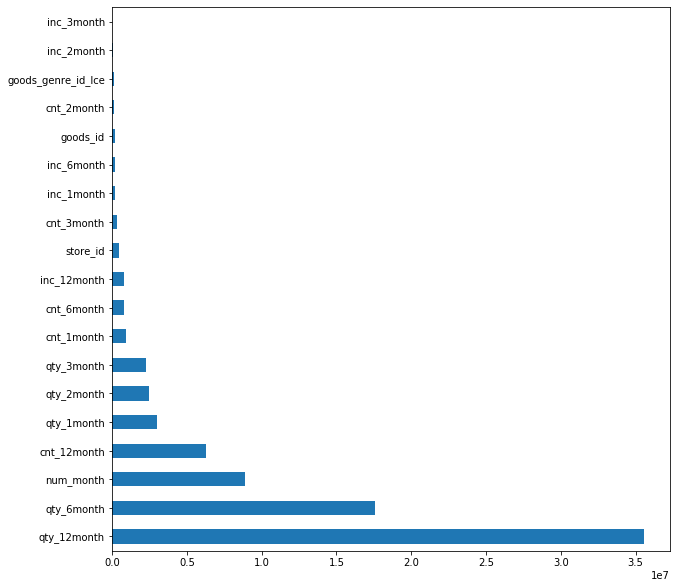

In [43]:
submission(main(),21)
#score: